# **F**ootball **A**nalysis in **R**eal **T**ime using **T**ransformer


Tony Robinson and Tanner Watts

In [ ]:
# mount the dataset (the drive)
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# set teh data directory location
DATA_DIREC = "/content/drive/MyDrive/FARTT/data/"
MAIN_DIREC = "/content/drive/MyDrive/FARTT"

### Setting up all needed libraries and packages

In [ ]:
! pip install SoccerNet --upgrade
! pip install pytorch_lightning
! pip install scikit-video
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import torch
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
import SoccerNet
import matplotlib.pyplot as plt
import sys
import os
import cv2
import numpy as np
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.functional import accuracy

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

torch.cuda.empty_cache()

Good to go!


# Setup the Dataset #

Unzip the frames

In [ ]:
import zipfile
import os

unzip_data = False
if unzip_data:
  for leagueName in os.listdir(DATA_DIREC):
    print(leagueName)
    for year in os.listdir(DATA_DIREC+leagueName+"/"):
      for game in os.listdir(DATA_DIREC+leagueName+"/"+year+"/"):
        v3LabelsFile_path = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "Labels-v3.json"
        v3FramesZipFile_path = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "Frames-v3.zip"
        unzippedFolder = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "unzippedFramesDir/"

        if os.path.isdir(unzippedFolder):
          continue
        # make sure the necessary v3 files are present
        if (os.path.isfile(v3LabelsFile_path) == True) and (os.path.isfile(v3FramesZipFile_path) == True):
          print(unzippedFolder)
          with zipfile.ZipFile(v3FramesZipFile_path, 'r') as zip_ref:
            zip_ref.extractall(unzippedFolder)

In [ ]:
import json
import pathlib
import os
import zipfile
import shutil



def split_png_images():
  """
  This method will loop through the drive, place
  the images into train and test folders inside of the
  train and test folders will be the class folders
  """
  for leagueName in os.listdir(DATA_DIREC):
    for year in os.listdir(DATA_DIREC+leagueName+"/"):
      print(year)
      for game in os.listdir(DATA_DIREC+leagueName+"/"+year+"/"):
        print(game)
        v3LabelsFile_path = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "Labels-v3.json"
        unzippedFolder = DATA_DIREC+leagueName+"/"+year+"/"+game+"/"+ "unzippedFramesDir/"
        # open the json for parsing
        if not (os.path.isfile(v3LabelsFile_path) and os.path.isdir(unzippedFolder)):
          continue
        game_json = open(v3LabelsFile_path)
        game_dict = json.load(game_json)

        for image in os.listdir(unzippedFolder):
          # get the class label from the json
          image = str(image)
          train_test_valid_folder ="none"
          if image in game_dict["actions"]:
            train_test_valid_folder = game_dict["actions"][image]["imageMetadata"]["set"]
          else:
            continue

          image_label = game_dict["actions"][image]["imageMetadata"]["label"]
          game_name = game_dict["actions"][image]["imageMetadata"]["localpath"]
          folder_path = DATA_DIREC + train_test_valid_folder + "/" + image_label
          # check to see if the directory exists if not create it
          if os.path.isdir(folder_path):
            print("Exists")
            print(folder_path)
          else:
            print("Doesn't exist")
            os.mkdir(folder_path)
          og_image_path = unzippedFolder + image
          # change the image
          image_name = game + "_" + image
          # do we need the whole path

          # img_full = unzippedFolder + image_name
          print(image_name)
          dst = os.path.join(folder_path, image_name)
          os.rename(og_image_path, dst)

split_im = False
if split_im:
  split_png_images()

In [ ]:
import glob
import numpy as np

## TODO: Figure how to split the data into 3 cats ##
def create_data_sets():
  # A common approach is to split your data into three sets: training, validation, and test.
  #The training set is used to train the model, the validation set is used to tune the model's
  # hyperparameters, and the test set is used to evaluate the final performance of the trained model.
  # The specific percentages of data used for each set will depend on the details of your project,
  # but a typical split might be *** 60% for training, 20% for validation, and 20% for test ***.
  # chucks are set to 6000
  ## get the sets of images ##
  train_data = []
  test_data = []
  val_data = []

  train_data_path = DATA_DIREC + "train"
  valid_data_path = DATA_DIREC + "valid"
  test_data_path = DATA_DIREC + "test"

  classes = [] #to store class values

  # This creates an array of image paths for train test and valid
  for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    for path in glob.glob(data_path + '/*'):
      # try :
      #   Image.open(path)
      # except:
      #   print("DNE")
      #   print(path)
      #   continue
      train_data.append(path)


  for data_path in glob.glob(valid_data_path + '/*'):
    for path in glob.glob(data_path + '/*'):
      val_data.append(path)

  for data_path in glob.glob(test_data_path + '/*'):
    for path in glob.glob(data_path + '/*'):
      test_data.append(path)


  # soccernet = SNV3Dataset(args.SoccerNet_path, split=args.split, resolution=(args.resolution_width,args.resolution_height), preload_images=args.preload_images, zipped_images=args.zipped_images, tiny=args.tiny)
  return train_data, test_data, val_data, classes


train_data, test_data, val_data, classes = create_data_sets()
train_data.remove(str(MAIN_DIREC +"/data/train/Foul/2015-02-17 - 22-45 Paris SG 1 - 1 Chelsea_4.png"))
if str(MAIN_DIREC +"/data/train/Foul/2015-02-17 - 22-45 Paris SG 1 - 1 Chelsea_4.png") in train_data:
  print("FAIL")

In [ ]:
print(classes)

['Foul', 'Goal', 'Ball out of play', 'Direct free-kick', 'Clearance', 'Corner', 'Offside', 'Penalty', 'Yellow card', 'Kick-off']


In [ ]:
#creating the dataset
#dataset
#######################################################
#               Define Transforms
#######################################################
import torchvision.transforms.functional as F

def square_pad( image):
  w, h= image.size
  max_wh = np.max([w, h])
  hp = int((max_wh - w) / 2)
  vp = int((max_wh - h) / 2)
  padding = (hp, vp, hp, vp)
  return F.pad(image, padding, 0, 'constant')



train_transforms_deep = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)


image_size = [3, 480, 854]

train_transforms = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),

])

test_transforms = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()

])


test_transforms_deep = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
from PIL import Image
# gives indexes to the classes for easy enumeration
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class Actions_Dataset(torch.utils.data.Dataset):
    def __init__(self, classes, image_paths, transform = None, target_transform = None):
        """
        classes: The classes in the dataset
        image_base_dir: The directory of the folders containing the images
        transform: The trasformations for the Images
        Target_transform: The trasformations for the target

        """
        self.img_labels = classes
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      """
      This method will get the item from the dataset. It will read using cv2
      """
      image_filepath = self.image_paths[idx]
      image = Image.open(image_filepath)
      label = image_filepath.split('/')[-2]
      label = class_to_idx[label]
      image = square_pad(image)
      # here we change the size of the images
      image = image.resize((100, 100))
      image = np.asarray(image)
      if self.transform is not None:
        image = self.transform(image=image)["image"]

      return image, label


In [ ]:
# Define your DataModule (if using one)
## TODO: look up the correct way to implement a lighingDataModule ##
class FARTTDataModule(pl.LightningDataModule):
  def __init__(self, classes, train_dir, val_dir, test_dir, train_data_paths,
               test_data_paths, val_data_paths, batch_size=64):
    # Load and preprocess your data
    self.batch_size = batch_size
    self.transform = train_transforms
    self.test_tansform = test_transforms
    self.num_classes = len(classes)
    self.train_data = Actions_Dataset(classes, train_data_paths, self.transform)
    self.val_data = Actions_Dataset(classes, val_data_paths, self.transform)
    self.test_data = Actions_Dataset(classes, test_data_paths, self.test_tansform)

  def setup(self):
    # call the data_loader which will use v3
     print("SETUP")

  def train_dataloader(self):
    # Return a DataLoader for the training data
    return torch.utils.data.DataLoader(self.train_data,
            batch_size=self.batch_size, shuffle=True, num_workers=12)

  def val_dataloader(self):
    # Return a DataLoader for
    return torch.utils.data.DataLoader(self.val_data,
            batch_size=self.batch_size, shuffle=False, num_workers=12)

  def test_dataloader(self):
    return torch.utils.data.DataLoader(self.test_data,
        batch_size=1, shuffle=False, num_workers=12)


In [ ]:
# load in the data splitting it into test train and val
train_data_path = DATA_DIREC + "/train"
valid_data_path = DATA_DIREC + "/valid"
test_data_path = DATA_DIREC + "/test"
# use the DataModule to pass to the model
data_module = FARTTDataModule(classes, train_data_path, valid_data_path, test_data_path, train_data, test_data, val_data)

# ResNet #

In [ ]:
class PlainBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.net = None
    # Documentation
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

    myStride = 1
    if downsample:
      myStride = 2


    self.net = nn.Sequential(
        nn.BatchNorm2d(Cin),
        nn.ReLU(),
        nn.Conv2d(in_channels=Cin, out_channels=Cout, kernel_size=3, stride=myStride, padding=1),
        nn.BatchNorm2d(Cout),
        nn.ReLU(),
        nn.Conv2d(in_channels=Cout, out_channels=Cout, kernel_size=3, stride=1, padding=1)
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = None # F
    self.shortcut = None # G

    self.block = PlainBlock(Cin, Cout, downsample)

    if (Cin == Cout) and not downsample:
      self.shortcut = nn.Identity()
    if (Cin != Cout) and not downsample:
      self.shortcut = nn.Conv2d(in_channels=Cin, out_channels=Cout, kernel_size=1, stride=1, padding=0)
    if downsample:
      self.shortcut = nn.Conv2d(in_channels=Cin, out_channels=Cout, kernel_size=1, stride=2, padding=0)


  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [ ]:
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()
    blocks = [block(Cin, Cout, downsample)]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))
    self.net = nn.Sequential(*blocks)

  def forward(self, x):
    return self.net(x)

In [ ]:
class ResNetStem(nn.Module):
  def __init__(self, Cin=3, Cout=8):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self, x):
    return self.net(x)

In [ ]:
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
}

In [ ]:
from torchmetrics.classification import MulticlassAccuracy

class ResNet(pl.LightningModule):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=len(classes),  learning_rate=0.025, num_epocs=100):
    super().__init__()

    self.cnn = None
    self.compute_loss = nn.CrossEntropyLoss()
    self.lr = learning_rate
    self.num_epocs = num_epocs

    stages = []
    for arg in stage_args:
      num_in_channels, num_out_channels, num_blocks, do_downsample = arg
      stages.append(ResNetStage(num_in_channels, num_out_channels, num_blocks, downsample = do_downsample, block = block))

    self.cnn = nn.Sequential(
        ResNetStem(),
        *stages,
        nn.AdaptiveAvgPool2d((1,1))
    )

    self.fc = nn.Linear(stage_args[-1][1], num_classes)

    self.save_hyperparameters()

  def forward(self, x):
    scores = None
    x = self.cnn(x)
    x = x.view(x.shape[0], -1)
    scores = self.fc(x)
    return scores

  def training_step(self, batch, batch_idx):
    # Compute the loss and log it for tracking
    input, target = batch
    output = self.forward(input)
    loss = self.compute_loss(output, target)
    logs = {'train_loss': loss}
    return {'loss': loss, 'log': logs}

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.compute_loss(logits, y)
    preds = torch.argmax(logits, dim=1)
    acc = accuracy(task='multiclass', num_classes=len(classes),
                    preds= preds, target=y)
    self.log("val_loss", loss, prog_bar=True)
    self.log("val_acc", acc, prog_bar=True)

  def test_step(self, batch, batch_indx):
    x, y = batch
    logits = self.forward(x)
    loss = self.compute_loss(logits, y)
    preds = torch.argmax(logits, dim=1)
    acc = accuracy(task='multiclass', num_classes=len(classes),
                    preds= preds, target=y)
    self.log("test_loss", {"loss":loss}, prog_bar=True)
    self.log("test_acc", {"acc" : acc}, prog_bar=True)


  def configure_optimizers(self):
    # Return the optimizer(s) to be used during training
    return torch.optim.Adam(self.parameters(), lr=self.lr)


def get_resnet(name):
  return ResNet(**networks[name])



# Train the Model #


In [ ]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

trained = False

if not trained:

  # set up hyperparams for our module
  # create an instance of our model
  model = get_resnet('resnet32')
  # create an instnace of the logger

  wandb_logger = WandbLogger(project="ResNet_Test", log_model="all")
  # (neptune) initialize a trainer and pass neptune_logger
  trainer = pl.Trainer(
      accelerator='gpu',
       max_epochs=25,
       devices=1,
       callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=20)],
      logger=wandb_logger,
  )

  trainer.fit(model, data_module.train_dataloader(), data_module.val_dataloader())
  wandb_logger.watch(model, log="all")

  fartt_model_path = MAIN_DIREC + '/resnet_wandb.ckpt'
  trainer.save_checkpoint(fartt_model_path)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanneraddington (fartt). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | compute_loss | CrossEntropyLoss | 0     
1 | cnn          | Sequential       | 117 K 
2 | fc           | Linear           | 330   
--------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.472     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val_acc,▂▃▄▃▃▂▃▄▁▃▄▇▃▆▅▄▂▇▂▆▇▆▂█▂
val_loss,▆▃▂▂▂▄▂▂█▃▂▁▂▁▁▂▅▁▄▁▁▁▂▁▄
epoch,24
trainer/global_step,2574
val_acc,0.49381
val_loss,1.56056


In [ ]:
# evaluate on the test data
model_ = get_resnet('resnet32')
trainer = pl.Trainer(
      accelerator='gpu',
       max_epochs=25,
       devices=1,
       callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=20)],
      logger=wandb_logger,
  )
trainer.test(model=model_, dataloaders=data_module.test_dataloader(), ckpt_path=fartt_model_path,)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/FARTT/resnet.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/FARTT/resnet.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc:acc          0.40934282541275024
     test_loss:loss         1.6682822704315186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': {'loss': tensor(1.6683, device='cuda:0')},
  'test_acc': {'acc': tensor(0.4093, device='cuda:0')}}]

## Evaluate on new Data ##
Here we can take any video and produce video captions of what is happening in the game.

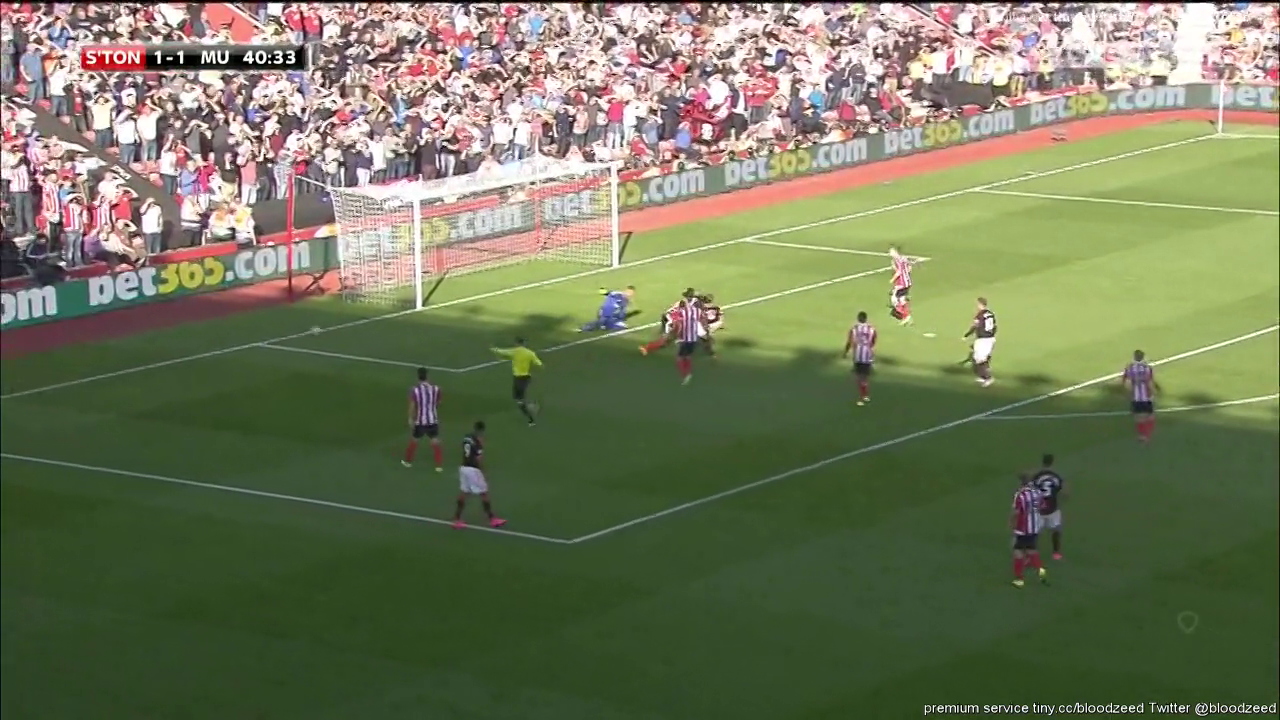

Ball out of play
Prediction: Ball out of play
Actual class: Ball out of play


In [ ]:
import matplotlib
from google.colab.patches import cv2_imshow
image_num = 10

img = cv2.imread(test_data[image_num], cv2.IMREAD_COLOR)
cv2_imshow(img)

image = Image.open(test_data[image_num])
label = test_data[image_num].split('/')[-2]
print(label)

image = square_pad(image)
# here we change the size of the images
image = image.resize((100, 100))
image = np.asarray(image)
image = test_transforms(image=image)["image"]
image = (image).float().unsqueeze(0)

model = get_resnet('resnet32').load_from_checkpoint(fartt_model_path)
model.eval()

with torch.no_grad():
  y_hat = model(image)

print("Prediction:", classes[torch.argmax(y_hat)])
print("Actual class:", label)

# make some visualisation. play video and print when the action happens. Replays